Introducción al Tracking con Deep Learning 
======

Esta demo muestra una aproximación para codificar el seguimiento de objetos (en este caso vehículos) empleando Deep Learning.

El dataset estará formado por imágenes de vehículos y por ejemplos negativos que se corresponderán con imágenes en las que no aparecen coches. 

Las imágenes que se emplearán (coches y no coches) se encontrarán respectivamente en las carpetas ./vehicles/ y ./non-vehicles/

In [8]:
import glob 
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure

In [2]:
cars = glob.glob("./vehicles/*/*.png")
non_cars = glob.glob("./non-vehicles/*/*.png")

# Generar el vector target Y que contendrá en primer lugar las etiquetas de los ejemplos positivos representadas con un 1
# y a continuación las de los ejemplos negativos, codifcadas con un -1.
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])

# Leer el vector X 
X = []
for name in cars:    
    X.append(skimage.io.imread(name)) # Devuelve un ndarray. Los diferentes canales de color se alamacenan en la 3ª dim
for name in non_cars:    
    X.append(skimage.io.imread(name))
X = np.array(X)

### Creación del Conjunto de Entrenamiento y de Test


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'ejemplos de entrenamiento')
print(X_test.shape[0], 'ejemplos de test')
input_shape =  (3,64,64)

X_train shape: (15984, 64, 64, 3)
15984 ejemplos de entrenamiento
1776 ejemplos de test


### Definición del Modelo de Clasificación con Keras

En esta definición no se emplea ninguna capa densa sino capas Convolution2D. El problema trata de distinguir entre 2 clases: 1 (coche) y -1 (no coche). Como función de loss se empleará MSE y como función de activación, tanh. Añadir más de 2 clases implica realizar una serie de modificaciones ya que se emplearía una softmax que requiere normalización en el eje adecuado (ver última celda)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K


def get_conv(input_shape=(64,64,3), filename=None):
    model = Sequential()
    # Normalización: Las imágenes tienen 3 canales de color y cada canal toma un valor entre 0 y 255. 
    # Además se empleará tanh por lo que el tensor tendrá rango entre -1 y 1. 
    # Xnorm = Xin / 127.5  - 1
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, (3, 3), activation='relu', name='conv1',input_shape=input_shape, padding="same"))
    model.add(Convolution2D(10, (3, 3), activation='relu', name='conv2', padding="same"))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128, (8, 8), activation="relu", name="dense1")) # En vez de Dense(128)
    model.add(Dropout(0.5))
    model.add(Convolution2D(1, (1,1), name="dense2", activation="tanh")) #  En vez de Dense(1)
    if filename:
        model.load_weights(filename)        
    return model

model = get_conv()
# Si la capa Flatten() recibiese un input_shape de (None, 64, 32. 32) devolvería un output_shape de (None, 65536)
model.add(Flatten())
# mse = k.mean(k.square(y_pred - y_true))
# binary accuracy = k.mean(k.equal(y_true, k.round(y_pred)))
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Score en el Conjunto de Test:', score[0])
print('Accuracy en el Conjunto de Test:', score[1])
model.save_weights("localiza.h5")

Train on 15984 samples, validate on 1776 samples
Epoch 1/20
15984/15984 [==============================] - 2s - loss: 0.5743 - acc: 0.4345 - val_loss: 0.4746 - val_acc: 0.6740
Epoch 2/20
15984/15984 [==============================] - 2s - loss: 0.2521 - acc: 0.7897 - val_loss: 0.1676 - val_acc: 0.8750
Epoch 3/20
15984/15984 [==============================] - 2s - loss: 0.1650 - acc: 0.8716 - val_loss: 0.1790 - val_acc: 0.8812
Epoch 4/20
15984/15984 [==============================] - 2s - loss: 0.1301 - acc: 0.9002 - val_loss: 0.0875 - val_acc: 0.9251
Epoch 5/20
15984/15984 [==============================] - 2s - loss: 0.1105 - acc: 0.9194 - val_loss: 0.0757 - val_acc: 0.9392
Epoch 6/20
15984/15984 [==============================] - 2s - loss: 0.1000 - acc: 0.9282 - val_loss: 0.0704 - val_acc: 0.9448
Epoch 7/20
15984/15984 [==============================] - 2s - loss: 0.0889 - acc: 0.9366 - val_loss: 0.0767 - val_acc: 0.9459
Epoch 8/20
15984/15984 [==============================] - 2s -

# Convertir el Clasificador en un Mapa de Calor

Como el modelo está formado por capas Conv2d, para obtener el mapa de calor no se especifican las dimensiones de la imagen y no se añade la capa Flatten() al final.

In [24]:
heatmodel = get_conv(input_shape=(None,None,3), filename="localize.h5")

El shape de la imagen de entrada es:  (720, 1280, 3)


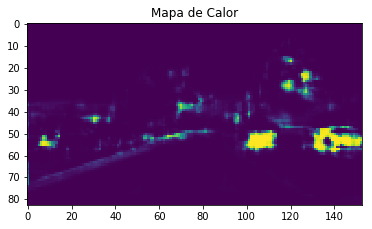

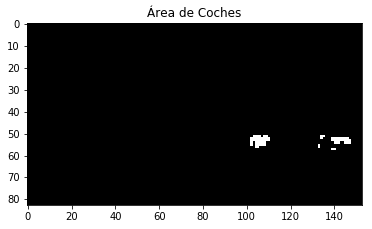

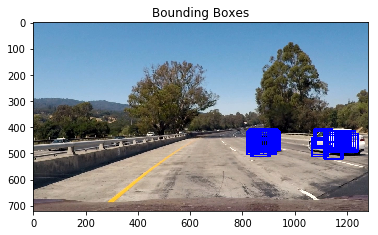

In [44]:
%matplotlib inline
import matplotlib.pylab as plt

def locate():
    data = (skimage.io.imread("test1.jpg"))
    print("El shape de la imagen de entrada es: ", data.shape)
    
    heatmap = heatmodel.predict(data.reshape(1,data.shape[0],data.shape[1],data.shape[2]))
    
    
    plt.imshow(heatmap[0,:,:,0])
    plt.title("Mapa de Calor")
    plt.show()
    plt.imshow(heatmap[0,:,:,0]>0.99, cmap="gray")
    plt.title("Área de Coches")
    plt.show()

    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.99])
    y = (yy[heatmap[0,:,:,0]>0.99])
    
    # zip devuelve una lista de tuplas. Cada tupla estará formada el elemento que está en la posición 'i' en cada 
    # iterable de entrada
    for i,j in zip(x,y):
        # cv2.rectangle(data, coord-esquina-sup-izq, coord-esquina-inf-dcha, canales-color ,grosor-línea-en-píxeles)
        cv2.rectangle(data, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)
    return data

annotated = locate()

plt.title("Bounding Boxes")    
plt.imshow(annotated)
plt.show()

### Más de 2 clases

Si hay más de 2 clases de salida se necesitará un Clasificador Softmax, pero su implementación en Keras 1.x sólo se aplica sobre la última dimensión de tensores de 2D (nb_samples, nb_dims) ó de 3D (nb_samples, nb_timesteps, nb_dims). Para solucionarlo se ha adaptado dicha función de activación dando lugar a 'Softmax4D'. 

<img src="softmax.jpg">


In [50]:
# Hay que adaptar el vector Y para que sea [0,1] y [1,0] en vez de -1 or 1
from customlayers import Softmax4D

def get_conv(input_shape=(64, 64, 3), filename=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(20, (3, 3), activation='relu', name='conv1', input_shape=input_shape, padding="same"))
    model.add(Convolution2D(20, (3, 3), activation='relu', name='conv2', padding="same"))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128, (8, 8), activation="relu", name="dense1"))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2, (1, 1), name="dense2"))
    #model.add(Softmax4D(axis=3, name="softmax"))
    model.add(Activation('softmax'))
    return model

model = get_conv()
model.add(Flatten())
model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [51]:
z = skimage.io.imread("test1.jpg")
zz = z.reshape(1, z.shape[0], z.shape[1], z.shape[2])
zz.shape
#print(K.max(zz, axis=3, keepdims=True))

(1, 720, 1280, 3)